# Deep Neural Network based Text-to-Speech

## Imports
* Keras(https://keras.io/)
* pySPTK(http://pysptk.readthedocs.io)
* h5py(http://www.h5py.org/)

In [1]:
%pylab inline

import numpy as np
import h5py
from keras.models import Model, Sequential, load_model
import pysptk
from pysptk.synthesis import MLSADF, Synthesizer
import librosa
from scipy.io import wavfile
from IPython.display import Audio
import matplotlib
rcParams['figure.figsize'] = (16, 5)

import generate_dataset as gd
import text_process as tp

Populating the interactive namespace from numpy and matplotlib


Using TensorFlow backend.


### Functions

In [2]:
def fix_inputs(data):
    columns = np.zeros((223))
    for i in range(200,215):
        columns[i] = 1
    a = np.array(data)
    new_matrix = (a-mean_[np.newaxis,:])/std_[np.newaxis,:]
    
    b = np.array(columns)
    ret = (a*(1-b[np.newaxis,:]))+(new_matrix*(b[np.newaxis,:]))
    return ret

In [3]:
def fix_outputs(output_data, max_min):
    return np.array(output_data*(max_min[0]-max_min[1])+max_min[1])

In [4]:
def predict(model, input_data, outputs_number):
    output_data = []
    for d in input_data:
        # timing prediction
        if (outputs_number == 8):
            d = np.array(d).reshape(1,213)
        # other predictions
        else:
            d = np.array(d).reshape(1,215)
        output_data.append(model.predict(d).reshape(outputs_number))
    return np.array(output_data)

In [5]:
def generate_audio(pitch, mc):
    source_excitation = pysptk.excite(pitch.copy(order='C'), 80)

    mc_ = np.apply_along_axis(pysptk.mc2b, 1, mc, alpha);
    synthesizer = Synthesizer(MLSADF(order=order, alpha=alpha), frame_step)

    mc_synthesized = synthesizer.synthesis(source_excitation, mc_)
    
    return mc_synthesized

## Prediction models
### Import train parameters

In [6]:
mean_ = []
with h5py.File('preprocessed_data/train-mean.h5','r') as hf:
    mean_ = np.array(hf.get('dataset'))
std_ = []
with h5py.File('preprocessed_data/train-std.h5','r') as hf:
    std_ = np.array(hf.get('dataset'))

In [7]:
rate = 16000
frame_size = 256
frame_step = 80
order = 5
alpha = 0.41

In [8]:
test_data = gd.generate_sentence_data(["arctic_a0303","But all my dreams violated this law."])
test_data = np.array(test_data)
test_data.shape

arctic_a0303
354


(354, 223)

In [9]:
test_data_ = fix_inputs(test_data)

## Learning data
Difference between the audio file and the inputs used for the training

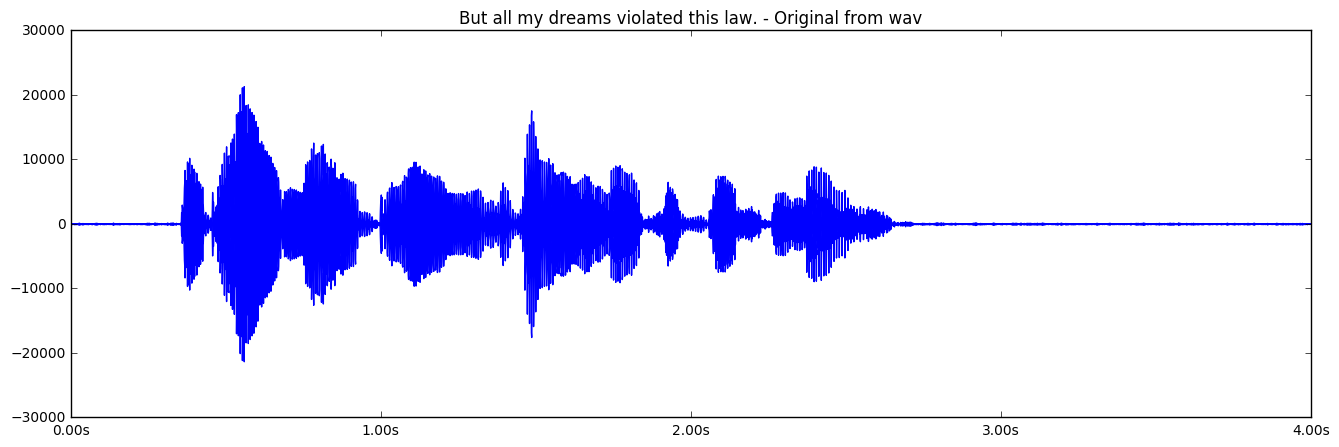

In [10]:
test_sound = wavfile.read('data_raw/wav/arctic_a0303.wav')[1]
librosa.display.waveplot(test_sound, sr=rate)
title("But all my dreams violated this law. - Original from wav")
Audio(test_sound, rate=rate)

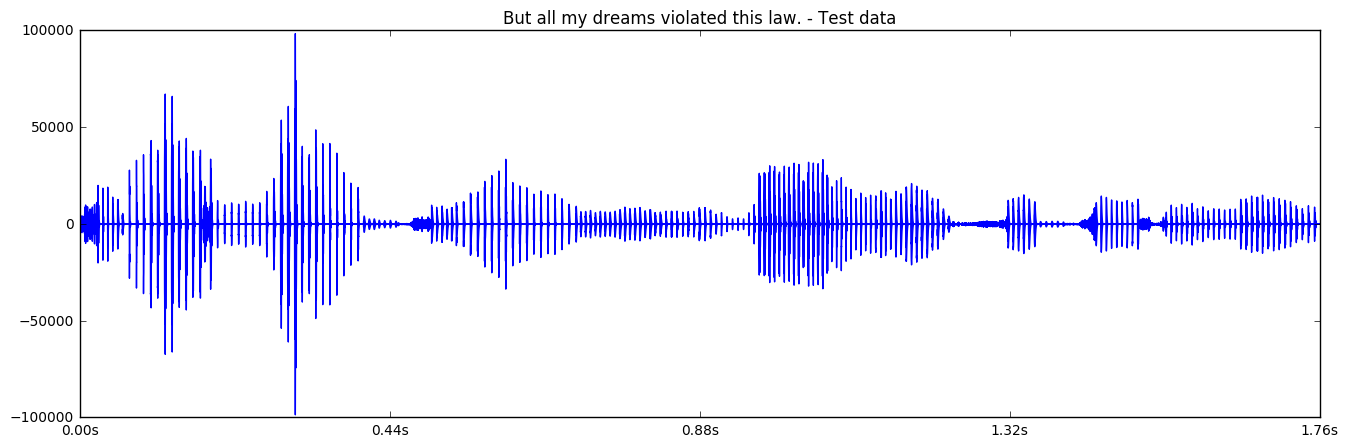

In [11]:
synthesized = generate_audio(pitch=test_data[:,215], mc=test_data[:,216:222])
librosa.display.waveplot(synthesized, sr=rate)
title("But all my dreams violated this law. - Test data")
Audio(synthesized, rate=rate)

## V/UV prediction

In [12]:
model_uv = load_model('models_data/model_uv.h5')
model_uv.load_weights('models_data/model_uv_weights.h5')
model_uv.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 512)           110592      dense_input_1[0][0]              
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 512)           262656      dense_1[0][0]                    
____________________________________________________________________________________________________
dense_3 (Dense)                  (None, 512)           262656      dense_2[0][0]                    
____________________________________________________________________________________________________
dense_4 (Dense)                  (None, 512)           262656      dense_3[0][0]                    
___________________________________________________________________________________________

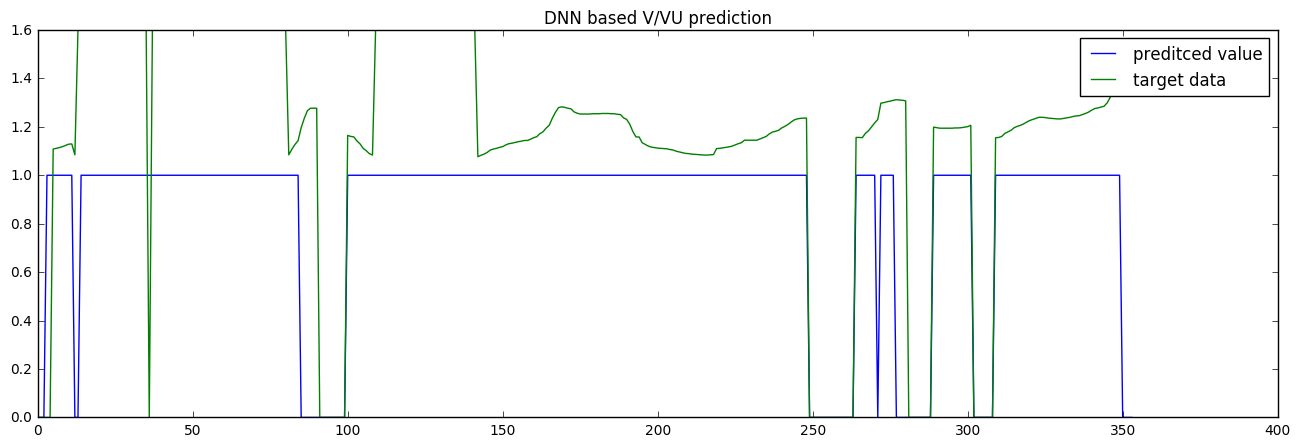

In [13]:
outputs_uv = predict(model_uv, test_data_[:,0:215], 2)
for o in outputs_uv:
    if o[0] > o[1]:
        o[0] = 1
    else:
        o[0] = 0
outputs_uv = np.array(outputs_uv)[:,0]

plot(outputs_uv, label='preditced value')
plot(test_data[:,215]/100, label='target data')
title('DNN based V/VU prediction')
legend()
show()

## Pitch prediction

In [14]:
model_pitch = load_model('models_data/model_pitch.h5')
model_pitch.load_weights('models_data/model_pitch_weights.h5')
model_pitch.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1024)          221184      dense_input_2[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1024)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1024)          1049600     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 1024)          0           dense_2[0][0]                    
___________________________________________________________________________________________

In [15]:
max_min_pitch = []
with h5py.File('models_data/max_min_pitch.h5','r') as hf:
    max_min_pitch = np.array(hf.get('dataset'))
max_min_pitch = np.array(max_min_pitch)

In [16]:
outputs_pitch = np.array(predict(model_pitch, test_data_[:,0:215], 1))
outputs_pitch = fix_outputs(outputs_pitch, max_min=max_min_pitch)

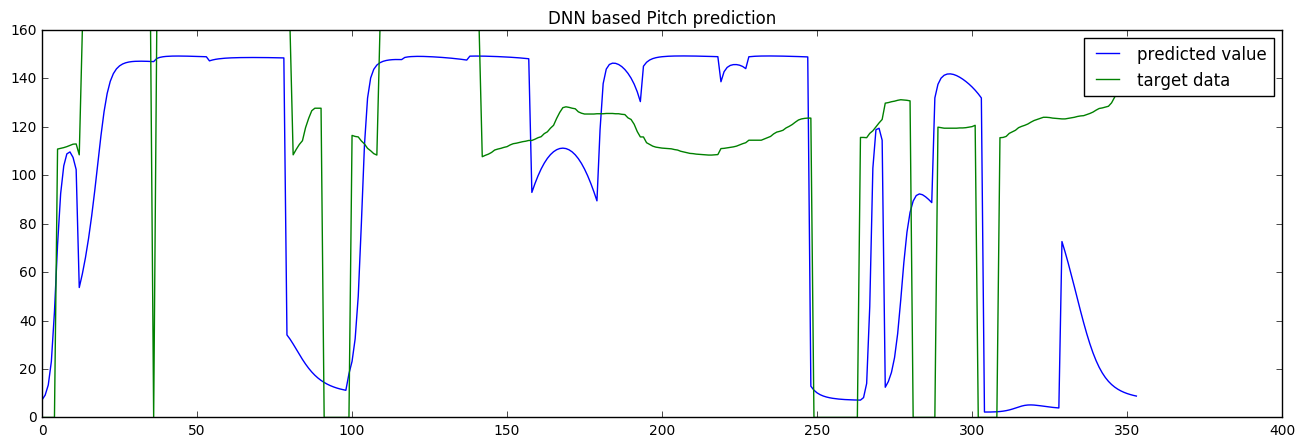

In [17]:
plot(outputs_pitch, label='predicted value')
plot(test_data[:,215], label='target data')
legend()
title('DNN based Pitch prediction')
show()

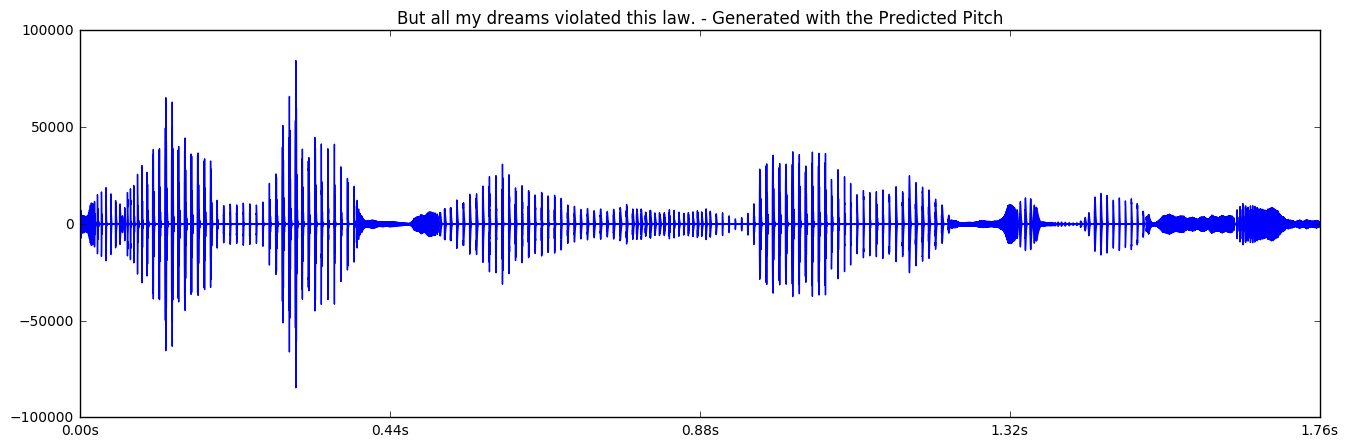

In [18]:
synthesized = generate_audio(pitch=outputs_pitch[:,0], mc=test_data[:,216:222])
librosa.display.waveplot(synthesized, sr=rate)
title("But all my dreams violated this law. - Generated with the Predicted Pitch")
Audio(synthesized, rate=rate)

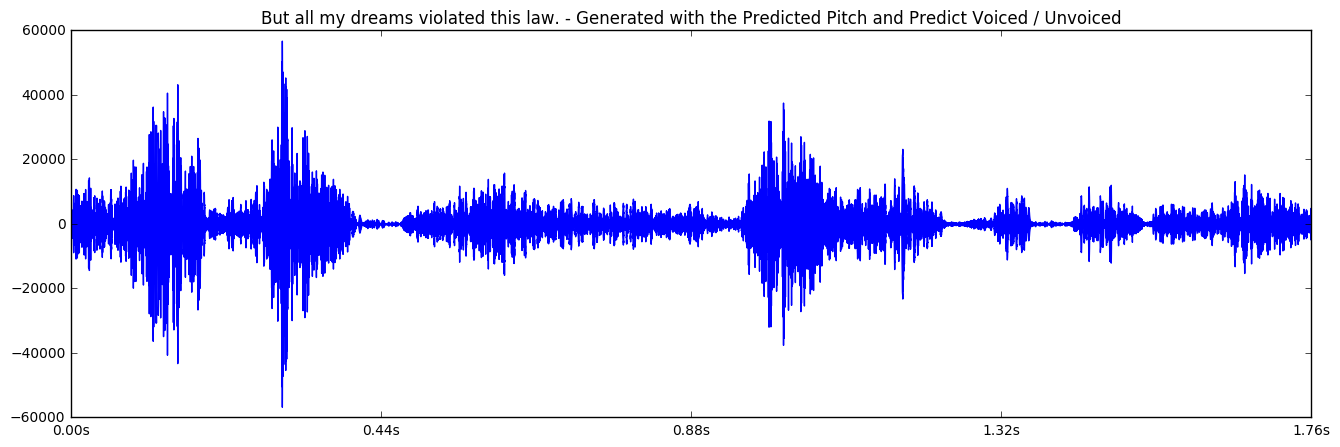

In [19]:
outputs_pitch_uv = outputs_pitch * outputs_uv
synthesized = generate_audio(pitch=outputs_pitch_uv[:,0], mc=test_data[:,216:222])
librosa.display.waveplot(synthesized, sr=rate)
title("But all my dreams violated this law. - Generated with the Predicted Pitch and Predict Voiced / Unvoiced")
Audio(synthesized, rate=rate)

## Mel-Cepstrum prediction

In [20]:
model_mc = load_model('models_data/model_mc.h5')
model_mc.load_weights('models_data/model_mc_weights.h5')
model_mc.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
dense_1 (Dense)                  (None, 1024)          221184      dense_input_3[0][0]              
____________________________________________________________________________________________________
dropout_1 (Dropout)              (None, 1024)          0           dense_1[0][0]                    
____________________________________________________________________________________________________
dense_2 (Dense)                  (None, 1024)          1049600     dropout_1[0][0]                  
____________________________________________________________________________________________________
dropout_2 (Dropout)              (None, 1024)          0           dense_2[0][0]                    
___________________________________________________________________________________________

In [21]:
max_min_mc = []
with h5py.File('models_data/max_min_mc.h5','r') as hf:
    max_min_mc = np.array(hf.get('dataset'))
max_min_mc = np.array(max_min_mc)

In [22]:
outputs_mc = np.array(predict(model_mc, test_data_[:,0:215], 6))
outputs_mc = fix_outputs(outputs_mc, max_min=max_min_mc)

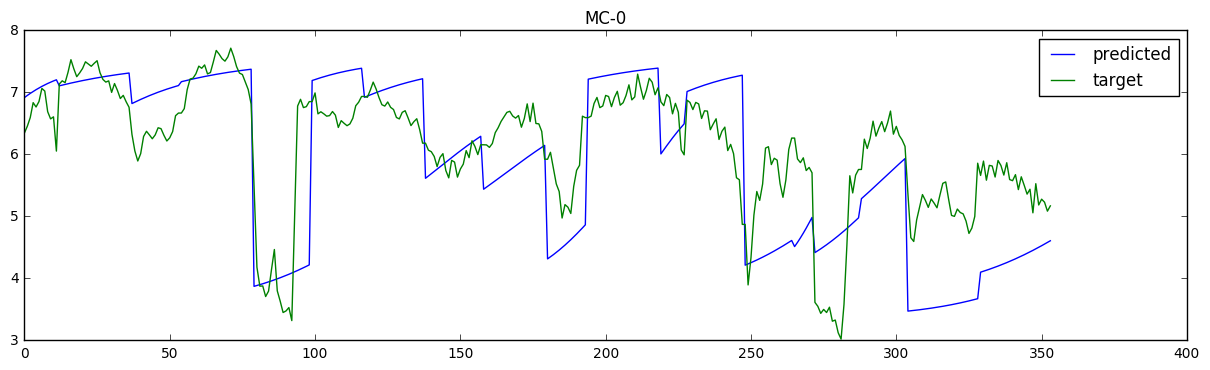

In [23]:
n=0

figure(figsize=(15,4))
title('MC-{}'.format(n))
plot(outputs_mc[:,n],label='predicted')
plot(test_data[:,216+n],label='target')
legend()
show()

In [ ]:
synthesized = generate_audio(pitch=test_data[:,215], mc=outputs_mc)
librosa.display.waveplot(synthesized, sr=rate)
title("But all my dreams violated this law. - Generated with MC prediction")
Audio(synthesized, rate=rate)

## Phoneme length prediction

In [ ]:
model_length = load_model('models_data/model_length.h5')
model_length.load_weights('models_data/model_length_weights.h5')
model_length.summary()

In [ ]:
classes = [8.0,10.0,12.5,15.0,17.5,20.0,22.5,25.0]
def predict_length(input_data):
    outputs = np.array(predict(model_length, input_data, len(classes)))
    output_new = []
    for o in outputs:
        k = 0
        for i in range(0,len(classes)):
            if o[i] >= o[k]:
                k = i
        output_new.append(classes[k])
    return output_new[0]

In [ ]:
def generate_tags(phonemes):
    tags = []
    for phoneme in phonemes:
        length = (int)(predict_length(np.array(phoneme[1]).reshape(1,213)))
        for f in range(0,length):
            tag = []
            tag.extend(phoneme[1])
            tag.append(length)
            tag.append(f/length)
            tags.append(tag)
    return np.array(tags)

In [ ]:
text_tags = tp.generate_tags("But all my dreams violated this law. - Generated with MC prediction")
tags = generate_tags(text_tags)

In [ ]:
outputs_uv = predict(model_uv, tags, 2)
for o in outputs_uv:
    if o[0] > o[1]:
        o[0] = 1
    else:
        o[0] = 0
outputs_uv = np.array(outputs_uv)[:,0]

In [ ]:
outputs_pitch = np.array(predict(model_pitch, tags, 1))
outputs_pitch = fix_outputs(outputs_pitch, max_min=max_min_pitch)

In [ ]:
outputs_mc = np.array(predict(model_mc, tags, 6))
outputs_mc = fix_outputs(outputs_mc, max_min=max_min_mc)

## Text to Speech
* Pitch prediction
* MC prediction
* Phoneme length prediction

In [ ]:
synthesized = generate_audio(pitch=outputs_pitch_uv[:,0], mc=outputs_mc)
librosa.display.waveplot(synthesized, sr=rate)
title("But all my dreams violated this law. - Generated with all predicted values")
Audio(synthesized, rate=rate)

In [ ]:
synthesized = generate_audio(pitch=test_data[:,215], mc=test_data[:,216:222])
librosa.display.waveplot(synthesized, sr=rate)
title("But all my dreams violated this law. - Target values")
Audio(synthesized, rate=rate)